<a href="https://colab.research.google.com/github/jajsmith/npi-topics/blob/master/npi_context_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NPI-Context: Using intervention context to inform literature search with case study

1. We make it easier to conduct literature search for new interventions in specific environments by incorporating the context for each intervention in our search.

2. We demonstrate this method on a newly constructed dataset of Canadian NPIs. To show the benefit we compare using general Oxford intervention categories as search terms with our method and demonstrate that new relevant research is surfaced.

## Introduction

The competition named "the COVID-19 Open Research Dataset (CORD-19)" has been launched to support experts in the healthcare domain quickly and accurately receive answers to their scientific questions related to coronaviruses. We can take advantage of NLP and ML tools to develop improved ways of finding relevant research to guide policy actions taken by governments and organizations around the world. CORD-19 encompasses 40,000 articles about coronaviruses. For the competition, 10 tasks have been proposed. Each task covers some fundamental questions related to COVID 19. In this submission, we focus on answering the questions in the task related to non-pharmaceutical interventions. In particular we aim to answer:

- What do we know about the effectiveness of non-pharmaceutical interventions?
- What is known about equity and barriers to compliance for non-pharmaceutical interventions?

## Method

### Searching the CORD-19 Dataset

We make use of the [covidex.io](https://covidex.io) project using the Anserini information retrieval toolkit via pyserini. All the documents in CORD-19 are indexed in Lucene. We build off the demonstration notebook found [here](https://colab.research.google.com/drive/1mrapJp6-RIB-3u6FaJVa4WEwFdEBOcTe) to setup the lucene index and search functionality.

Thanks to [Jimmy Lin](https://cs.uwaterloo.ca/~jimmylin/) from the University of Waterloo and [Kyunghyun Cho](http://www.kyunghyuncho.me/) from NYU and their team for building this.

### Building a Dataset of Intervention Events

Policy makers and researchers around the world use literature review to help each team, organization, and country understand the effectiveness of non-pharmaceutical interventions and barriers to compliance *for their specific circumstances*. Observing the leading countries in COVID-19 response like South Korea and China we see drastically different methods used to intervene. **Making use of country-specific context is an important part of improving search quality.**

In order to show the effectivenss of this it is important to have an up-to-date and thorough picture of each countries current interventions and how they are being implemented. One has been created for Canada to use as a case study.

The [howsmyflattening.ca](https://howsmyflattening.ca) team has compiled a dataset of non-pharmaceutical interventions in Canada with 60 intervention labels, 1838 events, and more than 900 unique information sources. Some of the authors of this notebook are contributors to the Canadian non-pharmaceutical interventions dataset. The dataset can be retrieved on Kaggle [here](https://www.kaggle.com/howsmyflattening/covid19-challenges#npi_canada.csv).

### Intervention Context using Topic Modeling

We use Latent Dirichlet Allocation [(Blei, et. al., 2003)](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) to find topics in the full text announcements recorded for all recorded interventions in the input dataset. We then use keywords from these topics to guide search of relevant documents, comparing and augmenting the search results of the labeled interventions themselves. **Crucially, we are not just modeling topics in existing research, but also in actual interventions to understand the relationships between them.**


## Putting it all together - A Case Study in Canada

Below we use Canadian intervention data as a case study for our approach. We apply topic modeling to the intervention text and compare the search results with our baseline approach and show that the context-keyword generation leads to new, relevant results.

# Setup

In [0]:
%%capture
!pip install pyserini==0.8.1.0
!pip install transformers
!pip install geopandas
!pip install pyLDAvis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import json
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from pyserini.search import pysearch


Let's grab the pre-built index:

In [0]:
%%capture
!wget https://www.dropbox.com/s/d6v9fensyi7q3gb/lucene-index-covid-2020-04-03.tar.gz
!tar xvfz lucene-index-covid-2020-04-03.tar.gz

Sanity check of index size (should be 1.5G):

In [6]:
!du -h lucene-index-covid-2020-04-03

1.5G	lucene-index-covid-2020-04-03


Prepare search of the database using BM25 scoring from pyserini/lucene/solr.

In [0]:
searcher = pysearch.SimpleSearcher('lucene-index-covid-2020-04-03/')

def search(search_strings, topk=5):
  columns = ['search', 'rank', 'title', 'score']
  results_df = pd.DataFrame()
  for search in search_strings:
    hits = searcher.search(search)
    #label_hits.append(hits)
    #print("")
    print("Search term: ", search)
    #print("  hits:", len(hits))
    scores = [h.score for h in hits]
    #print("  mean score:", np.mean(scores))
    #print("")
    for i in range(0, min(topk, len(hits))):
      #print(f'{i+1:2} {hits[i].docid} {hits[i].score:.5f} {hits[i].lucene_document.get("title")} {hits[i].lucene_document.get("doi")}')
      row_df = pd.DataFrame([[search, i+1, hits[i].lucene_document.get("title"), hits[i].score]], columns=columns)
      results_df = results_df.append(row_df)

  return results_df

# Canadian non-pharmaceutical interventions Dataset

The Canadian non-pharmaceutical interventions dataset covers compiled information from **January 1st to March 31st, 2020** across 13 provinces and territories as well as the largest 20 CMAs in Canada.
The 60 types of intervention contained in this dataset includes (but not restricted to) government announcements, initiatives, and orders, such as  social distancing measures or social and fiscal measures. The rest of the notebook will use this as the reference dataset for creating visualization and topic modelling.

### Dataset retrieval

Now let's grab the Canadian NPI dataset.

In [10]:
!wget https://raw.githubusercontent.com/jajsmith/COVID19NonPharmaceuticalInterventions/master/npi_canada.csv

--2020-05-07 02:49:15--  https://raw.githubusercontent.com/jajsmith/COVID19NonPharmaceuticalInterventions/master/npi_canada.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9503275 (9.1M) [text/plain]
Saving to: ‘npi_canada.csv’

npi_canada.csv      100%[===================>]   9.06M  19.3MB/s    in 0.5s    

2020-05-07 02:49:20 (19.3 MB/s) - ‘npi_canada.csv’ saved [9503275/9503275]



In [0]:
full_df = pd.read_csv('npi_canada.csv')
full_df['start_date'] = pd.to_datetime(full_df['start_date'])
full_df['end_date'] = pd.to_datetime(full_df['end_date'])
full_df['oxford_fiscal_measure_cad'] = full_df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)

In order to aid efforts to fight the pandemic, we aim to use a standard metric for analyzing the governments responses. The Oxford COVID-19 Government Response Tracker (OxCGRT) has collected the Coronavirus Government Response Tracker Dataset. The dataset is collected and updated in real time by a team of dozens of students and staff at Oxford University. This Dataset is available at this [link](https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker).
 They have provided 13 indicators of such responses. 9 of these metrics (S1-S7, S12, and S13) are non-financial policies such as event cancelation and the others (S8-S11) are financial indicators such as monetary measures. The Canadian NPI dataset linked all eligible interventions type to one of the Oxford categories. 
 A list of these indicators

Each indicator contains a range of values. For more information on the list of the indicators and the encodings visit the [Encodings](https://www.bsg.ox.ac.uk/sites/default/files/2020-04/BSG-WP-2020-031-v4.0_0.pdf).
Averaging the stringency numbers gives a composite index and allows us to understand how quickly and strinctly different areas of Canada reacted to COVID-19 over time. The Stringency Index is calculated using only the policy indicators S1 – S7. This metric is calculated by averaging the normalized values from each indicator. Further details on calculation of this index is provided at: [Calculation details](bsg.ox.ac.uk/sites/default/files/Calculation%20and%20presentation%20of%20the%20Stringency%20Index.pdf)

Note that this index simply records the number and strictness of government policies and should not be interpreted as ‘scoring’ the appropriateness or effectiveness of a country’s response.


# Retrieving Research from Expert NPI Labels

These are the labels used in the Canadian NPI dataset. It can be expected that they would provide a strong baseline for search results that can inform the Canadian response to COVID-19.

In [13]:
full_df['oxford_government_response_category'].astype(str).unique()

array(['S12 Testing policy', 'nan', 'S3 Cancel public events',
       'S5 Public info campaigns', 'S7 International travel controls',
       'S1 School Closing', 'S10 Emergency investment in health care',
       'S8 Fiscal measures', 'S6 Restrictions on internal movements',
       'S13 Contact tracing', 'S2 Workplace closing',
       'S4 Close public transport',
       'S9 Monetary measures (interest rate)',
       'S11 Investment in vaccines', 'S8 Fiscal Measures'], dtype=object)

In [21]:
results_df = search(full_df['oxford_government_response_category'].astype(str).unique())

Search term:  S12 Testing policy
Search term:  nan
Search term:  S3 Cancel public events
Search term:  S5 Public info campaigns
Search term:  S7 International travel controls
Search term:  S1 School Closing
Search term:  S10 Emergency investment in health care
Search term:  S8 Fiscal measures
Search term:  S6 Restrictions on internal movements
Search term:  S13 Contact tracing
Search term:  S2 Workplace closing
Search term:  S4 Close public transport
Search term:  S9 Monetary measures (interest rate)
Search term:  S11 Investment in vaccines
Search term:  S8 Fiscal Measures


In [17]:
results_df

,search,rank,title,score
0,S12 Testing policy,1,Polycistronic (tri- or bicistronic) phytoreovi...,6.9744
0,S12 Testing policy,2,Rice dwarf phytoreovirus segment S12 transcrip...,6.8681
0,S12 Testing policy,3,Examining the policies and guidelines around t...,4.5468
0,S12 Testing policy,4,An analytic framework to develop policies for ...,4.4463
0,S12 Testing policy,5,Unconsented HIV Testing in Cases of Occupation...,4.3935
...,...,...,...,...
0,S8 Fiscal Measures,1,S8 – S47 and O50 – O440,6.3496
0,S8 Fiscal Measures,2,Financing strategies to improve essential publ...,5.9198
0,S8 Fiscal Measures,3,Safety immunopharmacology: Evaluation of the a...,5.4645
0,S8 Fiscal Measures,4,Voicing an impact: who does the National Insti...,5.3083


# Keyword Selection from LDA Topics on Canadian NPI Full Text (gensim)

The topic modeling algorithm that we have utilized in this approach is one well-known generative probabilistic model that is referred to as **Latent Dirichlet Allocation (LDA)**

LDA receives words as an input vector and generates topics which are probability distribution over words based on a generative process. LDA uses a joint probability distribution over both the observed and hidden random variables and compute the posterior distribution (conditional distribution) of the hidden variables given the observed variables. **The fundamental assumption of LDA is that documents can be assigned to multiple topics**. Another assumption is that topics are hidden variables, and words in documents are visible variables. Thus, LDA performs a generative process by receiving words (*apparent variables*) as an input vector to provide topics (*hidden variables*) which are **probability distribution over words**


## Import Packages
The main package that we have used are *gensim*, *nltk* and *pandas*

In [22]:
import os
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import pandas
import re
import pandas
from pprint import pprint

2020-05-07 02:54:44,997 : INFO : 'pattern' package not found; tag filters are not available for English


## Read Data and Preprocessing
In this step we read the dataset and select the titles 

In [23]:
engl_df = full_df[full_df['region'] != 'Quebec']
full_text = engl_df['source_full_text'].drop_duplicates().astype(str)
data = full_text.values
data = [re.sub('\s+', ' ', text) for text in data] # remove new lines
data = [re.sub("\'", "", text) for text in data] # remove quotes
print("Total number of documents: ", len(data))

Total number of documents:  1291


In [24]:
words = [row.split() for row in data]

print(words[13:14])



[['Northwest', 'Territories', 'COVID-19', 'Economic', 'Relief', 'Yellowknife', '—', 'March', '20,', '2020News', 'Releases', 'The', 'Government', 'of', 'the', 'Northwest', 'Territories', '(GNWT)', 'recognizes', 'the', 'difficulties', 'that', 'the', 'COVID-19', 'pandemic', 'and', 'health', 'measures', 'being', 'taken', 'to', 'combat', 'the', 'virus’', 'spread', 'is', 'causing', 'NWT', 'businesses,', 'service', 'providers,', 'residents,', 'governments', 'and', 'non-government', 'organizations.', 'Today,', 'Minister', 'Caroline', 'Wawzonek,', 'Minister', 'of', 'Finance', 'and', 'Minister', 'Katrina', 'Nokleby,', 'Minister', 'of', 'Industry,', 'Tourism', 'and', 'Investment,', 'and', 'Infrastructure,', 'announced', 'Economic', 'Relief', 'Measures', 'that', 'will', 'help', 'minimize', 'expenses', 'and', 'keep', 'cash', 'available', 'for', 'immediate', 'needs', 'in', 'this', 'time', 'of', 'uncertainty.', 'The', 'GNWT', 'has', 'put', 'together', 'an', 'initial', 'economic', 'relief', 'package',

 ## Bigram and Trigram 
We need to provide Bigram and Trigram from the orginal texts. 

In [25]:

bigram = Phrases(words, min_count=30, progress_per=10000)
trigram = Phrases(bigram[words], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

bigrams = [b for l in data for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]


2020-05-07 02:54:45,354 : INFO : collecting all words and their counts
2020-05-07 02:54:45,356 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-07 02:54:46,315 : INFO : collected 214020 word types from a corpus of 574418 words (unigram + bigrams) and 1291 sentences
2020-05-07 02:54:46,316 : INFO : using 214020 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2020-05-07 02:54:46,321 : INFO : collecting all words and their counts
2020-05-07 02:54:46,327 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-07 02:54:49,467 : INFO : collected 222590 word types from a corpus of 534818 words (unigram + bigrams) and 1291 sentences
2020-05-07 02:54:49,468 : 


## NLTK Stop words

In [0]:

stop_words = stopwords.words('english')
#stop_words.extend(['school', 'Nonpharmaceutical Interventions', 'education'])


In [0]:
r = [x.split() for x in full_df['region'].dropna().unique().tolist()]
r = np.hstack([np.array(x) for x in r])
sr = [x.split() for x in full_df['subregion'].dropna().unique().tolist()]
sr = np.hstack([np.array(x) for x in sr])
geo_stop_words = np.append(r, sr)
geo_stop_words = [x.lower() for x in geo_stop_words]
geo_stop_words = [x.replace('(','').replace(')','') for x in geo_stop_words]


In [0]:
stop_words.extend(geo_stop_words)


In [0]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

words_nostops = remove_stopwords(words)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
words_bigrams = make_bigrams(words_nostops)

## Create the Dictionary and Corpus needed for Topic Modeling
The LDA function receives *Dictionary* and *Corpus* as inpuut and provides *Topics* as output


We creat dictionary using *corpora.Dictionary*

In [30]:
id2word = corpora.Dictionary(words_bigrams)



2020-05-07 02:54:56,515 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-07 02:54:56,807 : INFO : built Dictionary(12472 unique tokens: ['acquiring', 'act', 'actions', 'adults', 'advice']...) from 1291 documents (total 321978 corpus positions)


## Building the Topic Model
To train the LDA model, we need to define 1) the corpus, 2) dictionary and 3)the number of topics. We also need to determine the values of hyperparameters such as *alpha* and *eta*. The defult values of these parametters are $1/#topic$. Another parameter is *chunksize* that determines the number of documents to be used in each training chunk. Finally *passes* is the total number of training passes. 


In [31]:
texts = words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=35, 
                                       random_state=10,
                                       chunksize=100,
                                       passes=1,
                                       per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

2020-05-07 02:54:57,051 : INFO : using symmetric alpha at 0.02857142857142857
2020-05-07 02:54:57,052 : INFO : using symmetric eta at 0.02857142857142857
2020-05-07 02:54:57,056 : INFO : using serial LDA version on this node
2020-05-07 02:54:57,128 : INFO : running online (single-pass) LDA training, 35 topics, 1 passes over the supplied corpus of 1291 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-07 02:54:57,129 : INFO : PROGRESS: pass 0, at document #100/1291
2020-05-07 02:54:57,322 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:54:57,429 : INFO : topic #30 (0.029): 0.018*"covid" + 0.015*"canada" + 0.012*"health" + 0.010*"services" + 0.009*"support" + 0.008*"government" + 0.008*"help" + 0.006*"food" + 0.006*"care" + 0.006*"information"
2020-05-07 02:54:57,431 : INFO : topic #11 (0.029): 0.014*"covid" + 0.009*"nwt" + 0.009*"public_he

[(10,
  '0.039*"collection" + 0.031*"waste" + 0.023*"garbage" + 0.023*"items" + '
  '0.015*"bags" + 0.014*"please" + 0.012*"services" + 0.012*"residents" + '
  '0.011*"recycling" + 0.009*"covid"'),
 (13,
  '0.046*"income" + 0.033*"benefit" + 0.031*"employment" + 0.019*"youth" + '
  '0.018*"program" + 0.016*"housing" + 0.014*"assistance" + 0.013*"excluding" '
  '+ 0.012*"lost" + 0.011*"laid"'),
 (6,
  '0.027*"student" + 0.022*"interest" + 0.019*"payments" + 0.019*"payment" + '
  '0.018*"nl" + 0.017*"permit" + 0.017*"financial" + 0.017*"th" + '
  '0.016*"animal" + 0.016*"bridge"'),
 (15,
  '0.025*"covid" + 0.015*"province" + 0.010*"health" + 0.010*"said" + '
  '0.010*"emergency" + 0.008*"public_health" + 0.007*"premier" + 0.007*"also" '
  '+ 0.006*"date" + 0.006*"continue"'),
 (22,
  '0.028*"covid" + 0.021*"equipment" + 0.019*"supplies" + 0.018*"government" + '
  '0.017*"health" + 0.014*"research" + 0.011*"minister" + 0.011*"masks" + '
  '0.011*"personal_protective" + 0.009*"advise"'),
 

In [32]:
Perplexity = lda_model.log_perplexity(corpus)
print ("Perplexity:", Perplexity)

2020-05-07 02:55:04,642 : INFO : -8.198 per-word bound, 293.6 perplexity estimate based on a held-out corpus of 1291 documents with 321978 words


Perplexity: -8.197668210516785



# Compute Coherence Score
A good LDA model can provide coherent topics. So its topic coherence is high. 

In [33]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2020-05-07 02:55:04,694 : INFO : using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2020-05-07 02:55:04,804 : INFO : WordOccurrenceAccumulator accumulated stats from 1000 documents
2020-05-07 02:55:04,928 : INFO : WordOccurrenceAccumulator accumulated stats from 2000 documents
2020-05-07 02:55:05,029 : INFO : WordOccurrenceAccumulator accumulated stats from 3000 documents
2020-05-07 02:55:05,142 : INFO : WordOccurrenceAccumulator accumulated stats from 4000 documents
2020-05-07 02:55:05,219 : INFO : WordOccurrenceAccumulator accumulated stats from 5000 documents
2020-05-07 02:55:05,342 : INFO : WordOccurrenceAccumulator accumulated stats from 6000 documents
2020-05-07 02:55:05,473 : INFO : WordOccurrenceAccumulator accumulated stats from 7000 documents
2020-05-07 02:55:05,562 : INFO : WordOccurrenceAccumulator accumulated stats from 8000 documents
2020-05-07 02:55:05,653 : INFO : WordOccurrenceAccumulator accumulated stats from 9000 documents
2020-05-07 02:5


Coherence Score:  0.44599228313165007


## What is an optimal LDA model ? 
How can we find the best values of Hyperparameters such as number of topics ( Model Hyperparameters) and alpha and beta that are reffered to as Document-Topic Density and and Word-Topic Density, respectivly and known as "Dirichlet hyperparameters". 

### 1. The number of Topics 

In [34]:
start=1
limit=50
step=2
coherence_values = []
model_list = []
for num_topics in range(start, limit, step):
    print('Topics: ', num_topics)
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=10,
                                       chunksize=100,
                                       passes=4,
                                       per_word_topics=True)
    model_list.append(lda_model)
    coherence_model_lda_c_v = CoherenceModel(model=lda_model, texts=words_bigrams, corpus=corpus, dictionary=id2word, coherence="c_v")
    coherence_values.append(coherence_model_lda_c_v.get_coherence())




2020-05-07 02:55:32,738 : INFO : using symmetric alpha at 1.0
2020-05-07 02:55:32,739 : INFO : using symmetric eta at 1.0
2020-05-07 02:55:32,744 : INFO : using serial LDA version on this node
2020-05-07 02:55:32,748 : INFO : running online (multi-pass) LDA training, 1 topics, 4 passes over the supplied corpus of 1291 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-07 02:55:32,748 : INFO : PROGRESS: pass 0, at document #100/1291
2020-05-07 02:55:32,771 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:55:32,774 : INFO : topic #0 (1.000): 0.016*"covid" + 0.012*"canada" + 0.008*"government" + 0.008*"public_health" + 0.007*"support" + 0.007*"health" + 0.006*"help" + 0.006*"nwt" + 0.005*"minister" + 0.005*"services"
2020-05-07 02:55:32,775 : INFO : topic diff=2.527687, rho=1.000000
2020-05-07 02:55:32,776 : INFO : PROGRESS: pass 0, at documen

Topics:  1


2020-05-07 02:55:32,941 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:55:32,945 : INFO : topic #0 (1.000): 0.021*"covid" + 0.011*"health" + 0.008*"ca" + 0.007*"people" + 0.006*"information" + 0.005*"cases" + 0.005*"self" + 0.005*"support" + 0.005*"bc" + 0.005*"services"
2020-05-07 02:55:32,947 : INFO : topic diff=0.454011, rho=0.377964
2020-05-07 02:55:32,948 : INFO : PROGRESS: pass 0, at document #800/1291
2020-05-07 02:55:32,972 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:55:32,976 : INFO : topic #0 (1.000): 0.020*"covid" + 0.011*"health" + 0.006*"people" + 0.006*"support" + 0.006*"ca" + 0.005*"services" + 0.005*"government" + 0.005*"public_health" + 0.005*"information" + 0.004*"emergency"
2020-05-07 02:55:32,977 : INFO : topic diff=0.445474, rho=0.353553
2020-05-07 02:55:32,977 : INFO : PROGRESS: pass 0, at document #900/1291
2020-05-07 02:55:32,999 : INFO : merging changes from 100 documents int

Topics:  3


2020-05-07 02:55:39,654 : INFO : topic #0 (0.333): 0.021*"canada" + 0.017*"covid" + 0.013*"government" + 0.010*"canadians" + 0.009*"health" + 0.008*"support" + 0.007*"help" + 0.006*"would" + 0.006*"businesses" + 0.006*"minister"
2020-05-07 02:55:39,656 : INFO : topic #1 (0.333): 0.015*"covid" + 0.011*"ca" + 0.008*"residents" + 0.008*"canada" + 0.008*"services" + 0.007*"link" + 0.007*"support" + 0.006*"help" + 0.006*"also" + 0.005*"community"
2020-05-07 02:55:39,657 : INFO : topic #2 (0.333): 0.013*"covid" + 0.008*"canada" + 0.007*"ca" + 0.006*"people" + 0.005*"public" + 0.005*"services" + 0.005*"community" + 0.005*"public_health" + 0.005*"health" + 0.005*"residents"
2020-05-07 02:55:39,658 : INFO : topic diff=1.031933, rho=0.707107
2020-05-07 02:55:39,659 : INFO : PROGRESS: pass 0, at document #300/1291
2020-05-07 02:55:39,736 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:55:39,744 : INFO : topic #0 (0.333): 0.017*"covid" + 0.015*"canada" + 0.

Topics:  5


2020-05-07 02:55:51,275 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:55:51,286 : INFO : topic #0 (0.200): 0.017*"canada" + 0.015*"covid" + 0.012*"government" + 0.008*"support" + 0.008*"would" + 0.007*"canadians" + 0.007*"help" + 0.007*"businesses" + 0.007*"health" + 0.006*"workers"
2020-05-07 02:55:51,287 : INFO : topic #1 (0.200): 0.015*"covid" + 0.011*"ca" + 0.009*"residents" + 0.009*"link" + 0.007*"services" + 0.006*"also" + 0.006*"community" + 0.006*"canada" + 0.006*"support" + 0.006*"help"
2020-05-07 02:55:51,289 : INFO : topic #2 (0.200): 0.012*"covid" + 0.007*"people" + 0.007*"ca" + 0.006*"community" + 0.006*"canada" + 0.006*"public_health" + 0.006*"public" + 0.005*"link" + 0.005*"services" + 0.005*"external"
2020-05-07 02:55:51,290 : INFO : topic #3 (0.200): 0.024*"canada" + 0.019*"covid" + 0.014*"canadians" + 0.011*"health" + 0.009*"government" + 0.008*"support" + 0.007*"parks" + 0.007*"minister" + 0.006*"help" + 0.006*"safety"
2020-

Topics:  7


2020-05-07 02:56:05,116 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:56:05,130 : INFO : topic #1 (0.143): 0.015*"covid" + 0.014*"link" + 0.014*"ca" + 0.010*"residents" + 0.007*"community" + 0.006*"services" + 0.006*"also" + 0.006*"information" + 0.006*"public_health" + 0.005*"help"
2020-05-07 02:56:05,132 : INFO : topic #0 (0.143): 0.019*"canada" + 0.015*"covid" + 0.013*"government" + 0.007*"would" + 0.007*"canadians" + 0.007*"health" + 0.007*"support" + 0.007*"workers" + 0.007*"help" + 0.006*"businesses"
2020-05-07 02:56:05,133 : INFO : topic #6 (0.143): 0.013*"covid" + 0.012*"support" + 0.008*"canada" + 0.008*"businesses" + 0.007*"march" + 0.007*"help" + 0.006*"program" + 0.006*"government" + 0.006*"period" + 0.005*"provide"
2020-05-07 02:56:05,134 : INFO : topic #5 (0.143): 0.016*"covid" + 0.009*"care" + 0.008*"canada" + 0.008*"ca" + 0.007*"also" + 0.006*"services" + 0.006*"people" + 0.006*"residents" + 0.005*"pandemic" + 0.005*"community"

Topics:  9


2020-05-07 02:56:20,915 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:56:20,935 : INFO : topic #6 (0.111): 0.013*"covid" + 0.012*"support" + 0.007*"canada" + 0.007*"businesses" + 0.007*"help" + 0.006*"program" + 0.006*"march" + 0.006*"government" + 0.006*"indigenous" + 0.005*"period"
2020-05-07 02:56:20,937 : INFO : topic #8 (0.111): 0.026*"canada" + 0.012*"support" + 0.012*"government" + 0.010*"covid" + 0.010*"canadians" + 0.008*"businesses" + 0.008*"help" + 0.007*"measures" + 0.007*"canadian" + 0.006*"minister"
2020-05-07 02:56:20,939 : INFO : topic #1 (0.111): 0.016*"link" + 0.015*"ca" + 0.015*"covid" + 0.010*"residents" + 0.007*"services" + 0.007*"community" + 0.007*"also" + 0.007*"information" + 0.006*"mail" + 0.005*"public_health"
2020-05-07 02:56:20,940 : INFO : topic #5 (0.111): 0.014*"covid" + 0.009*"yesterday" + 0.007*"care" + 0.007*"ca" + 0.007*"people" + 0.007*"also" + 0.007*"canada" + 0.006*"residents" + 0.006*"community" + 0.005*

Topics:  11


2020-05-07 02:56:38,350 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:56:38,372 : INFO : topic #5 (0.091): 0.014*"covid" + 0.008*"people" + 0.008*"residents" + 0.008*"parks" + 0.007*"canada" + 0.007*"also" + 0.007*"care" + 0.007*"ca" + 0.007*"community" + 0.006*"yesterday"
2020-05-07 02:56:38,374 : INFO : topic #2 (0.091): 0.010*"covid" + 0.008*"public_health" + 0.007*"canada" + 0.007*"ca" + 0.007*"external" + 0.006*"people" + 0.006*"emergency" + 0.006*"public" + 0.006*"spread" + 0.006*"link"
2020-05-07 02:56:38,376 : INFO : topic #1 (0.091): 0.014*"covid" + 0.013*"ca" + 0.010*"link" + 0.010*"residents" + 0.008*"services" + 0.007*"community" + 0.007*"public_health" + 0.006*"also" + 0.006*"information" + 0.005*"canada"
2020-05-07 02:56:38,377 : INFO : topic #0 (0.091): 0.016*"canada" + 0.014*"covid" + 0.012*"government" + 0.009*"health" + 0.008*"public_health" + 0.007*"emergency" + 0.006*"help" + 0.005*"businesses" + 0.005*"response" + 0.005*"c

Topics:  13


2020-05-07 02:56:57,222 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:56:57,247 : INFO : topic #5 (0.077): 0.014*"covid" + 0.011*"yesterday" + 0.009*"people" + 0.008*"care" + 0.008*"also" + 0.007*"residents" + 0.007*"ca" + 0.007*"community" + 0.006*"hall" + 0.006*"public"
2020-05-07 02:56:57,249 : INFO : topic #12 (0.077): 0.013*"covid" + 0.010*"canada" + 0.010*"health" + 0.008*"ca" + 0.007*"residents" + 0.007*"help" + 0.006*"services" + 0.006*"support" + 0.006*"need" + 0.005*"canadians"
2020-05-07 02:56:57,250 : INFO : topic #8 (0.077): 0.026*"canada" + 0.012*"government" + 0.012*"support" + 0.011*"canadians" + 0.010*"covid" + 0.009*"businesses" + 0.008*"help" + 0.008*"workers" + 0.007*"canadian" + 0.007*"minister"
2020-05-07 02:56:57,252 : INFO : topic #7 (0.077): 0.022*"covid" + 0.008*"canada" + 0.008*"march" + 0.008*"ca" + 0.007*"property" + 0.007*"health" + 0.005*"public_health" + 0.005*"need" + 0.005*"spread" + 0.004*"may"
2020-05-07 02:

Topics:  15


2020-05-07 02:57:18,480 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:57:18,509 : INFO : topic #8 (0.067): 0.030*"canada" + 0.012*"covid" + 0.011*"government" + 0.009*"canadians" + 0.009*"support" + 0.008*"measures" + 0.008*"health" + 0.007*"minister" + 0.007*"help" + 0.007*"canadian"
2020-05-07 02:57:18,511 : INFO : topic #13 (0.067): 0.018*"would" + 0.013*"eligible" + 0.011*"help" + 0.011*"covid" + 0.011*"employers" + 0.009*"support" + 0.009*"canada" + 0.008*"canadians" + 0.007*"subsidy" + 0.006*"businesses"
2020-05-07 02:57:18,512 : INFO : topic #11 (0.067): 0.012*"covid" + 0.008*"also" + 0.007*"ca" + 0.006*"canada" + 0.006*"residents" + 0.006*"yesterday" + 0.005*"public" + 0.005*"park" + 0.005*"public_health" + 0.005*"centre"
2020-05-07 02:57:18,513 : INFO : topic #1 (0.067): 0.019*"ca" + 0.016*"link" + 0.016*"covid" + 0.011*"residents" + 0.009*"inquiries" + 0.008*"services" + 0.007*"community" + 0.007*"mail" + 0.007*"public_health" + 0.00

Topics:  17


2020-05-07 02:57:42,204 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:57:42,237 : INFO : topic #11 (0.059): 0.020*"yesterday" + 0.011*"covid" + 0.008*"canada" + 0.007*"number" + 0.006*"public" + 0.006*"institution" + 0.006*"also" + 0.006*"public_health" + 0.006*"continue" + 0.005*"health"
2020-05-07 02:57:42,238 : INFO : topic #0 (0.059): 0.020*"canada" + 0.016*"covid" + 0.015*"government" + 0.010*"health" + 0.008*"emergency" + 0.007*"canadians" + 0.007*"public_health" + 0.007*"response" + 0.007*"help" + 0.006*"airport"
2020-05-07 02:57:42,239 : INFO : topic #9 (0.059): 0.013*"covid" + 0.011*"equipment" + 0.008*"said" + 0.008*"police" + 0.008*"building" + 0.006*"community" + 0.006*"canada" + 0.006*"external" + 0.005*"hospital" + 0.005*"including"
2020-05-07 02:57:42,240 : INFO : topic #3 (0.059): 0.026*"canada" + 0.018*"covid" + 0.016*"canadians" + 0.015*"parks" + 0.015*"health" + 0.008*"minister" + 0.007*"hall" + 0.007*"government" + 0.006*"p

Topics:  19


2020-05-07 02:58:06,609 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:58:06,647 : INFO : topic #13 (0.053): 0.018*"would" + 0.014*"eligible" + 0.012*"covid" + 0.011*"link" + 0.011*"help" + 0.009*"employers" + 0.008*"program" + 0.007*"food" + 0.007*"support" + 0.007*"canada"
2020-05-07 02:58:06,648 : INFO : topic #6 (0.053): 0.014*"support" + 0.012*"covid" + 0.012*"businesses" + 0.009*"canada" + 0.009*"march" + 0.008*"indigenous" + 0.008*"help" + 0.007*"government" + 0.007*"financial" + 0.006*"well"
2020-05-07 02:58:06,652 : INFO : topic #8 (0.053): 0.030*"canada" + 0.015*"government" + 0.014*"canadians" + 0.013*"support" + 0.011*"covid" + 0.009*"businesses" + 0.008*"help" + 0.008*"workers" + 0.008*"measures" + 0.007*"would"
2020-05-07 02:58:06,654 : INFO : topic #1 (0.053): 0.018*"covid" + 0.017*"ca" + 0.012*"link" + 0.011*"residents" + 0.009*"community" + 0.008*"services" + 0.007*"public_health" + 0.007*"inquiries" + 0.006*"avoid" + 0.006*"in

Topics:  21


2020-05-07 02:58:32,912 : INFO : topic #11 (0.048): 0.014*"covid" + 0.011*"canada" + 0.008*"public_health" + 0.007*"health" + 0.007*"support" + 0.006*"government" + 0.006*"measures" + 0.006*"nwt" + 0.006*"inmates" + 0.006*"also"
2020-05-07 02:58:32,914 : INFO : topic #1 (0.048): 0.017*"covid" + 0.012*"nwt" + 0.011*"public_health" + 0.009*"services" + 0.008*"residents" + 0.008*"government" + 0.007*"canada" + 0.007*"help" + 0.006*"support" + 0.006*"health"
2020-05-07 02:58:32,915 : INFO : topic #15 (0.048): 0.018*"covid" + 0.012*"public_health" + 0.010*"support" + 0.009*"nwt" + 0.008*"emergency" + 0.007*"government" + 0.007*"health" + 0.007*"canada" + 0.006*"minister" + 0.006*"residents"
2020-05-07 02:58:32,916 : INFO : topic diff=16.053299, rho=1.000000
2020-05-07 02:58:32,918 : INFO : PROGRESS: pass 0, at document #200/1291
2020-05-07 02:58:33,072 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:58:33,111 : INFO : topic #1 (0.048): 0.018*"covid" 

Topics:  23


2020-05-07 02:59:00,922 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:59:00,967 : INFO : topic #12 (0.043): 0.015*"canada" + 0.014*"covid" + 0.009*"health" + 0.007*"government" + 0.007*"support" + 0.007*"help" + 0.006*"minister" + 0.006*"residents" + 0.006*"businesses" + 0.005*"public_health"
2020-05-07 02:59:00,968 : INFO : topic #9 (0.043): 0.010*"covid" + 0.009*"canada" + 0.008*"health" + 0.007*"said" + 0.007*"services" + 0.006*"government" + 0.006*"support" + 0.005*"people" + 0.005*"also" + 0.005*"patients"
2020-05-07 02:59:00,969 : INFO : topic #13 (0.043): 0.017*"food" + 0.014*"covid" + 0.013*"help" + 0.009*"support" + 0.009*"canada" + 0.008*"canadians" + 0.007*"government" + 0.006*"communities" + 0.006*"people" + 0.006*"funding"
2020-05-07 02:59:00,970 : INFO : topic #5 (0.043): 0.015*"covid" + 0.012*"canada" + 0.010*"public_health" + 0.008*"medical" + 0.007*"services" + 0.006*"pandemic" + 0.006*"minister" + 0.006*"mask" + 0.005*"govern

Topics:  25


2020-05-07 02:59:31,935 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 02:59:32,001 : INFO : topic #3 (0.040): 0.019*"covid" + 0.017*"canada" + 0.011*"health" + 0.008*"canadians" + 0.008*"support" + 0.007*"government" + 0.006*"minister" + 0.006*"help" + 0.006*"time" + 0.005*"services"
2020-05-07 02:59:32,002 : INFO : topic #12 (0.040): 0.015*"canada" + 0.015*"covid" + 0.010*"health" + 0.008*"help" + 0.007*"information" + 0.007*"support" + 0.007*"government" + 0.006*"residents" + 0.006*"nwt" + 0.006*"measures"
2020-05-07 02:59:32,007 : INFO : topic #9 (0.040): 0.013*"covid" + 0.013*"public_health" + 0.010*"police" + 0.009*"said" + 0.008*"protect" + 0.008*"canada" + 0.007*"services" + 0.007*"health" + 0.007*"government" + 0.006*"equipment"
2020-05-07 02:59:32,010 : INFO : topic #8 (0.040): 0.023*"canada" + 0.011*"support" + 0.010*"government" + 0.010*"covid" + 0.008*"measures" + 0.008*"businesses" + 0.008*"help" + 0.006*"communities" + 0.006*"minist

Topics:  27


2020-05-07 03:00:04,888 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:00:04,960 : INFO : topic #13 (0.037): 0.018*"food" + 0.012*"covid" + 0.011*"help" + 0.010*"canada" + 0.009*"support" + 0.008*"canadians" + 0.007*"government" + 0.006*"communities" + 0.006*"workers" + 0.006*"pandemic"
2020-05-07 03:00:04,962 : INFO : topic #23 (0.037): 0.019*"covid" + 0.010*"support" + 0.010*"canada" + 0.009*"government" + 0.009*"food" + 0.008*"nwt" + 0.007*"help" + 0.006*"residents" + 0.006*"services" + 0.006*"communities"
2020-05-07 03:00:04,964 : INFO : topic #22 (0.037): 0.027*"canada" + 0.017*"government" + 0.016*"covid" + 0.009*"canadian" + 0.008*"health" + 0.008*"canadians" + 0.008*"help" + 0.007*"support" + 0.007*"equipment" + 0.007*"workers"
2020-05-07 03:00:04,972 : INFO : topic #11 (0.037): 0.012*"covid" + 0.010*"public_health" + 0.009*"canada" + 0.008*"inmates" + 0.007*"measures" + 0.007*"place" + 0.006*"health" + 0.006*"also" + 0.005*"support" + 

Topics:  29


2020-05-07 03:00:39,973 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:00:40,050 : INFO : topic #10 (0.034): 0.019*"canada" + 0.019*"covid" + 0.015*"government" + 0.009*"canadians" + 0.009*"support" + 0.007*"help" + 0.006*"minister" + 0.006*"measures" + 0.006*"health" + 0.006*"services"
2020-05-07 03:00:40,054 : INFO : topic #22 (0.034): 0.029*"canada" + 0.016*"government" + 0.014*"covid" + 0.009*"canadian" + 0.008*"help" + 0.008*"canadians" + 0.007*"support" + 0.007*"health" + 0.007*"equipment" + 0.006*"food"
2020-05-07 03:00:40,058 : INFO : topic #12 (0.034): 0.014*"canada" + 0.014*"covid" + 0.009*"health" + 0.008*"support" + 0.007*"help" + 0.006*"government" + 0.006*"information" + 0.006*"businesses" + 0.006*"nwt" + 0.005*"canadians"
2020-05-07 03:00:40,062 : INFO : topic #23 (0.034): 0.021*"covid" + 0.010*"government" + 0.009*"support" + 0.009*"canada" + 0.008*"nwt" + 0.008*"health" + 0.007*"services" + 0.007*"pandemic" + 0.007*"help" + 0.0

Topics:  31


2020-05-07 03:01:17,216 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:01:17,298 : INFO : topic #16 (0.032): 0.016*"covid" + 0.011*"canada" + 0.008*"support" + 0.007*"minister" + 0.007*"nwt" + 0.006*"businesses" + 0.006*"also" + 0.006*"help" + 0.006*"health" + 0.006*"government"
2020-05-07 03:01:17,303 : INFO : topic #3 (0.032): 0.023*"covid" + 0.015*"canada" + 0.011*"health" + 0.008*"support" + 0.008*"canadians" + 0.007*"nwt" + 0.006*"information" + 0.006*"residents" + 0.006*"time" + 0.006*"government"
2020-05-07 03:01:17,308 : INFO : topic #22 (0.032): 0.030*"canada" + 0.018*"government" + 0.016*"covid" + 0.010*"canadian" + 0.009*"help" + 0.008*"canadians" + 0.008*"equipment" + 0.008*"health" + 0.007*"support" + 0.007*"need"
2020-05-07 03:01:17,313 : INFO : topic #26 (0.032): 0.016*"canada" + 0.014*"covid" + 0.012*"measures" + 0.010*"public_health" + 0.007*"people" + 0.007*"spread" + 0.006*"seniors" + 0.006*"health" + 0.006*"help" + 0.005*"pr

Topics:  33


2020-05-07 03:01:57,978 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:01:58,064 : INFO : topic #2 (0.030): 0.013*"public_health" + 0.010*"emergency" + 0.008*"covid" + 0.008*"protect" + 0.008*"education" + 0.007*"nwt" + 0.007*"canada" + 0.007*"people" + 0.006*"go" + 0.005*"chief"
2020-05-07 03:01:58,066 : INFO : topic #31 (0.030): 0.015*"covid" + 0.011*"loan" + 0.009*"emergency" + 0.008*"public_health" + 0.007*"support" + 0.006*"government" + 0.006*"canada" + 0.006*"chief" + 0.005*"residents" + 0.005*"th"
2020-05-07 03:01:58,067 : INFO : topic #16 (0.030): 0.018*"covid" + 0.012*"canada" + 0.011*"public_health" + 0.008*"businesses" + 0.008*"emergency" + 0.007*"government" + 0.007*"support" + 0.006*"pandemic" + 0.006*"help" + 0.006*"nwt"
2020-05-07 03:01:58,069 : INFO : topic #1 (0.030): 0.018*"covid" + 0.015*"nwt" + 0.009*"residents" + 0.009*"government" + 0.008*"canada" + 0.008*"public_health" + 0.007*"support" + 0.006*"help" + 0.006*"services"

Topics:  35


2020-05-07 03:02:40,034 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:02:40,124 : INFO : topic #30 (0.029): 0.018*"covid" + 0.015*"canada" + 0.012*"health" + 0.010*"services" + 0.009*"support" + 0.008*"government" + 0.008*"help" + 0.006*"food" + 0.006*"care" + 0.006*"information"
2020-05-07 03:02:40,126 : INFO : topic #11 (0.029): 0.014*"covid" + 0.009*"nwt" + 0.009*"public_health" + 0.008*"canada" + 0.006*"also" + 0.006*"protect" + 0.006*"health" + 0.006*"support" + 0.005*"government" + 0.005*"minister"
2020-05-07 03:02:40,127 : INFO : topic #10 (0.029): 0.022*"covid" + 0.018*"canada" + 0.013*"government" + 0.009*"support" + 0.007*"health" + 0.007*"canadians" + 0.006*"help" + 0.006*"services" + 0.006*"minister" + 0.006*"measures"
2020-05-07 03:02:40,128 : INFO : topic #26 (0.029): 0.015*"canada" + 0.014*"covid" + 0.014*"public_health" + 0.012*"measures" + 0.008*"people" + 0.007*"spread" + 0.007*"health" + 0.006*"protect" + 0.005*"vessels" + 0

Topics:  37


2020-05-07 03:03:24,886 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:03:24,983 : INFO : topic #33 (0.027): 0.017*"covid" + 0.010*"support" + 0.009*"canada" + 0.008*"help" + 0.008*"businesses" + 0.007*"indigenous" + 0.007*"public_health" + 0.007*"food" + 0.007*"services" + 0.006*"minister"
2020-05-07 03:03:24,984 : INFO : topic #5 (0.027): 0.013*"covid" + 0.013*"public_health" + 0.010*"canada" + 0.007*"pandemic" + 0.006*"government" + 0.006*"minister" + 0.006*"emergency" + 0.005*"medical" + 0.005*"electricity" + 0.005*"power"
2020-05-07 03:03:24,986 : INFO : topic #31 (0.027): 0.019*"covid" + 0.018*"loan" + 0.010*"canada" + 0.009*"support" + 0.009*"online" + 0.007*"businesses" + 0.007*"th" + 0.007*"communities" + 0.007*"interest" + 0.006*"loans"
2020-05-07 03:03:24,987 : INFO : topic #34 (0.027): 0.012*"covid" + 0.010*"canada" + 0.009*"workers" + 0.008*"businesses" + 0.008*"help" + 0.007*"food" + 0.006*"sheets" + 0.006*"including" + 0.006*"bus

Topics:  39


2020-05-07 03:04:13,448 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:04:13,554 : INFO : topic #17 (0.026): 0.018*"public_health" + 0.015*"nwt" + 0.012*"covid" + 0.010*"chief" + 0.007*"education" + 0.007*"health" + 0.007*"support" + 0.007*"residents" + 0.007*"communities" + 0.006*"enforcement"
2020-05-07 03:04:13,556 : INFO : topic #36 (0.026): 0.017*"canada" + 0.013*"businesses" + 0.011*"covid" + 0.009*"business" + 0.008*"government" + 0.007*"help" + 0.006*"provide" + 0.006*"support" + 0.006*"credit" + 0.005*"including"
2020-05-07 03:04:13,557 : INFO : topic #27 (0.026): 0.023*"public_health" + 0.013*"covid" + 0.010*"nwt" + 0.008*"officer" + 0.008*"services" + 0.008*"residents" + 0.008*"pdf" + 0.007*"chief" + 0.007*"provide" + 0.007*"contact"
2020-05-07 03:04:13,558 : INFO : topic #31 (0.026): 0.022*"covid" + 0.011*"canada" + 0.010*"businesses" + 0.009*"support" + 0.008*"loan" + 0.006*"measures" + 0.006*"communities" + 0.006*"business" + 0.00

Topics:  41


2020-05-07 03:05:07,821 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:05:07,927 : INFO : topic #35 (0.024): 0.021*"food" + 0.018*"covid" + 0.017*"canada" + 0.012*"help" + 0.009*"government" + 0.008*"support" + 0.006*"minister" + 0.006*"pandemic" + 0.005*"health" + 0.005*"funding"
2020-05-07 03:05:07,929 : INFO : topic #4 (0.024): 0.018*"covid" + 0.013*"health" + 0.013*"public_health" + 0.012*"nwt" + 0.010*"services" + 0.010*"education" + 0.009*"government" + 0.008*"residents" + 0.008*"gnwt" + 0.008*"communities"
2020-05-07 03:05:07,930 : INFO : topic #27 (0.024): 0.031*"public_health" + 0.011*"covid" + 0.011*"officer" + 0.010*"kandola" + 0.009*"pdf" + 0.009*"chief" + 0.009*"emergency" + 0.008*"residents" + 0.008*"dr" + 0.008*"services"
2020-05-07 03:05:07,931 : INFO : topic #7 (0.024): 0.025*"covid" + 0.012*"canada" + 0.011*"public_health" + 0.009*"health" + 0.008*"canadians" + 0.007*"government" + 0.007*"loan" + 0.007*"measures" + 0.006*"supp

Topics:  43


2020-05-07 03:06:03,682 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:06:03,795 : INFO : topic #42 (0.023): 0.036*"food" + 0.020*"canada" + 0.012*"help" + 0.012*"covid" + 0.012*"canadians" + 0.010*"support" + 0.010*"government" + 0.009*"workers" + 0.008*"minister" + 0.008*"work"
2020-05-07 03:06:03,797 : INFO : topic #15 (0.023): 0.018*"covid" + 0.012*"support" + 0.011*"public_health" + 0.010*"nwt" + 0.008*"emergency" + 0.007*"minister" + 0.007*"government" + 0.006*"canada" + 0.006*"health" + 0.006*"measures"
2020-05-07 03:06:03,798 : INFO : topic #12 (0.023): 0.015*"canada" + 0.013*"covid" + 0.010*"health" + 0.010*"support" + 0.007*"government" + 0.007*"residents" + 0.007*"emergency" + 0.006*"businesses" + 0.006*"help" + 0.006*"public_health"
2020-05-07 03:06:03,799 : INFO : topic #27 (0.023): 0.030*"public_health" + 0.011*"covid" + 0.011*"officer" + 0.010*"kandola" + 0.009*"chief" + 0.009*"emergency" + 0.009*"residents" + 0.008*"dr" + 0.008*

Topics:  45


2020-05-07 03:07:01,034 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:07:01,153 : INFO : topic #28 (0.022): 0.014*"covid" + 0.012*"business" + 0.012*"canada" + 0.012*"businesses" + 0.009*"support" + 0.007*"government" + 0.006*"communities" + 0.006*"people" + 0.006*"services" + 0.006*"help"
2020-05-07 03:07:01,155 : INFO : topic #8 (0.022): 0.020*"canada" + 0.011*"government" + 0.010*"covid" + 0.009*"support" + 0.008*"workers" + 0.007*"communities" + 0.007*"help" + 0.007*"measures" + 0.007*"businesses" + 0.006*"also"
2020-05-07 03:07:01,157 : INFO : topic #29 (0.022): 0.016*"covid" + 0.013*"health" + 0.011*"canada" + 0.011*"services" + 0.011*"government" + 0.009*"public_health" + 0.009*"gnwt" + 0.007*"support" + 0.007*"lab" + 0.007*"right"
2020-05-07 03:07:01,158 : INFO : topic #38 (0.022): 0.018*"covid" + 0.015*"premier" + 0.012*"public_health" + 0.012*"community" + 0.012*"spread" + 0.011*"nwt" + 0.011*"cochrane" + 0.011*"help" + 0.010*"measur

Topics:  47


2020-05-07 03:08:03,109 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:08:03,230 : INFO : topic #29 (0.021): 0.020*"canada" + 0.013*"health" + 0.013*"covid" + 0.013*"government" + 0.010*"public_health" + 0.009*"equipment" + 0.009*"hand_sanitizer" + 0.009*"support" + 0.009*"lab" + 0.008*"taiga"
2020-05-07 03:08:03,232 : INFO : topic #34 (0.021): 0.016*"workers" + 0.014*"covid" + 0.013*"canada" + 0.011*"food" + 0.009*"employers" + 0.008*"help" + 0.007*"temporary" + 0.006*"support" + 0.006*"businesses" + 0.006*"foreign"
2020-05-07 03:08:03,233 : INFO : topic #21 (0.021): 0.019*"covid" + 0.013*"canada" + 0.010*"services" + 0.009*"canadians" + 0.007*"government" + 0.007*"health" + 0.007*"public_health" + 0.006*"help" + 0.006*"may" + 0.006*"gnwt"
2020-05-07 03:08:03,234 : INFO : topic #1 (0.021): 0.019*"covid" + 0.011*"nwt" + 0.010*"symptoms" + 0.010*"gnwt" + 0.009*"canada" + 0.009*"public_health" + 0.009*"government" + 0.008*"residents" + 0.008*"yel

Topics:  49


2020-05-07 03:09:03,593 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:09:03,715 : INFO : topic #8 (0.020): 0.023*"canada" + 0.010*"government" + 0.010*"tool" + 0.010*"covid" + 0.009*"assessment" + 0.009*"support" + 0.008*"help" + 0.008*"self" + 0.007*"residents" + 0.007*"communities"
2020-05-07 03:09:03,716 : INFO : topic #7 (0.020): 0.030*"covid" + 0.018*"public_health" + 0.010*"health" + 0.008*"government" + 0.008*"canada" + 0.007*"yellowknife" + 0.007*"officer" + 0.006*"emergency" + 0.006*"spread" + 0.006*"uf"
2020-05-07 03:09:03,720 : INFO : topic #6 (0.020): 0.015*"covid" + 0.009*"help" + 0.008*"businesses" + 0.008*"canada" + 0.007*"government" + 0.007*"spread" + 0.006*"support" + 0.005*"liquor" + 0.005*"may" + 0.005*"services"
2020-05-07 03:09:03,721 : INFO : topic #33 (0.020): 0.019*"covid" + 0.013*"support" + 0.010*"businesses" + 0.009*"services" + 0.009*"indigenous" + 0.008*"canada" + 0.008*"government" + 0.008*"nwt" + 0.008*"help" + 

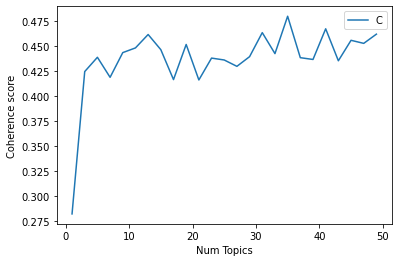

In [35]:
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("CoherenceValues"), loc='best')
plt.show()



In [36]:
PT=coherence_values[10:40]
print(PT)

[0.41638484974486994, 0.438276292594103, 0.43637755841394577, 0.4300165759336321, 0.4397204660673284, 0.4637733252609393, 0.4427607121904535, 0.4801860539194112, 0.4386891786479406, 0.4369045518615083, 0.467615412144769, 0.4356046429281893, 0.4560883246021109, 0.4530169886322671, 0.4622556699029836]


In [37]:
Optimal_N_Topic=35#PT.index(max(PT))+10
print(Optimal_N_Topic)

35


### Run LDA with the optimal number of topics 

In [38]:
texts = words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

Optimal_lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=Optimal_N_Topic, 
                                       random_state=10,
                                       chunksize=100,
                                       passes=1,
                                       per_word_topics=True)

pprint(Optimal_lda_model.print_topics())
doc_lda = Optimal_lda_model[corpus]

2020-05-07 03:10:03,697 : INFO : using symmetric alpha at 0.02857142857142857
2020-05-07 03:10:03,698 : INFO : using symmetric eta at 0.02857142857142857
2020-05-07 03:10:03,703 : INFO : using serial LDA version on this node
2020-05-07 03:10:03,776 : INFO : running online (single-pass) LDA training, 35 topics, 1 passes over the supplied corpus of 1291 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-07 03:10:03,777 : INFO : PROGRESS: pass 0, at document #100/1291
2020-05-07 03:10:03,978 : INFO : merging changes from 100 documents into a model of 1291 documents
2020-05-07 03:10:04,069 : INFO : topic #30 (0.029): 0.018*"covid" + 0.015*"canada" + 0.012*"health" + 0.010*"services" + 0.009*"support" + 0.008*"government" + 0.008*"help" + 0.006*"food" + 0.006*"care" + 0.006*"information"
2020-05-07 03:10:04,070 : INFO : topic #11 (0.029): 0.014*"covid" + 0.009*"nwt" + 0.009*"public_he

[(10,
  '0.039*"collection" + 0.031*"waste" + 0.023*"garbage" + 0.023*"items" + '
  '0.015*"bags" + 0.014*"please" + 0.012*"services" + 0.012*"residents" + '
  '0.011*"recycling" + 0.009*"covid"'),
 (13,
  '0.046*"income" + 0.033*"benefit" + 0.031*"employment" + 0.019*"youth" + '
  '0.018*"program" + 0.016*"housing" + 0.014*"assistance" + 0.013*"excluding" '
  '+ 0.012*"lost" + 0.011*"laid"'),
 (6,
  '0.027*"student" + 0.022*"interest" + 0.019*"payments" + 0.019*"payment" + '
  '0.018*"nl" + 0.017*"permit" + 0.017*"financial" + 0.017*"th" + '
  '0.016*"animal" + 0.016*"bridge"'),
 (15,
  '0.025*"covid" + 0.015*"province" + 0.010*"health" + 0.010*"said" + '
  '0.010*"emergency" + 0.008*"public_health" + 0.007*"premier" + 0.007*"also" '
  '+ 0.006*"date" + 0.006*"continue"'),
 (22,
  '0.028*"covid" + 0.021*"equipment" + 0.019*"supplies" + 0.018*"government" + '
  '0.017*"health" + 0.014*"research" + 0.011*"minister" + 0.011*"masks" + '
  '0.011*"personal_protective" + 0.009*"advise"'),
 

## visualization
*pyLDAvis* is a python package to provide interactive web-based visualization to describe the topics that have been provided by the LDA model. 

In [39]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt



2020-05-07 03:10:08,166 : INFO : Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
2020-05-07 03:10:08,191 : INFO : Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt


In [40]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(Optimal_lda_model, corpus, id2word)
vis

2020-05-07 03:10:09,887 : INFO : NumExpr defaulting to 2 threads.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.164780 -0.079103       1        1  15.685347
20     0.221612  0.097373       2        1   9.168351
4      0.148858 -0.101044       3        1   6.170479
1      0.208159  0.089739       4        1   6.025510
8     -0.041705 -0.254126       5        1   5.538579
23     0.037595 -0.178645       6        1   4.936768
2     -0.005112  0.159737       7        1   4.324011
27     0.113665  0.080847       8        1   3.820632
12     0.121813 -0.044375       9        1   3.483734
5      0.113078  0.035382      10        1   3.121517
22     0.013170 -0.100573      11        1   3.058270
25     0.140185  0.025205      12        1   2.998831
30     0.129457 -0.040561      13        1   2.775104
7      0.102913  0.057397      14        1   2.685344
18     0.098895  0.147567      15        1   2.515285
21     0.021753 -0.100153      16        1   2.432518
17     0.139860  0.090621      17        1   2.351903
32     0.077660 -0.030632      18        1   2.328187
14     0.079710 -0.022064      19        1   1.964270
3      0.015727  0.029783      20        1   1.884588
10     0.018006 -0.006205      21        1   1.304541
11    -0.162875  0.106537      22        1   1.254081
9     -0.102943  0.109753      23        1   1.212960
6     -0.109018 -0.110429      24        1   1.205801
0     -0.086005 -0.143061      25        1   1.133681
26     0.015734  0.062528      26        1   1.087076
34    -0.087614  0.014268      27        1   0.965081
19    -0.139485 -0.025365      28        1   0.845401
24    -0.078119 -0.130682      29        1   0.812050
13    -0.168301 -0.131011      30        1   0.772663
28    -0.113598  0.071472      31        1   0.697831
31    -0.221866  0.029234      32        1   0.475883
16    -0.234574  0.076050      33        1   0.373187
29    -0.205863  0.122085      34        1   0.314512
33    -0.225551  0.092449      35        1   0.276027, topic_info=                Term         Freq        Total Category  logprob  loglift
1267            said  1333.000000  1333.000000  Default  30.0000  30.0000
254             self  1406.000000  1406.000000  Default  29.0000  29.0000
674             care   823.000000   823.000000  Default  28.0000  28.0000
219    public_health  2298.000000  2298.000000  Default  27.0000  27.0000
116           health  3218.000000  3218.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1723            site     8.146979   256.056854  Topic35  -4.6922   2.4447
2301          higher     5.772675    64.747498  Topic35  -5.0367   3.4751
798            allow     5.003931   211.019943  Topic35  -5.1796   2.1507
767            sites     4.882579   323.853882  Topic35  -5.2041   1.6978
10698       waterloo     4.459460   205.601669  Topic35  -5.2948   2.0615

[2122 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3807     26  0.892974    abide
580       3  0.144655   abroad
580      13  0.036164   abroad
580      18  0.723273   abroad
5868     22  0.864699  absence
...     ...       ...      ...
470      19  0.196870    youth
470      30  0.312276    youth
2792      1  0.911097     zone
2792      2  0.086397     zone
2803     16  0.897488    zones

[8371 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 21, 5, 2, 9, 24, 3, 28, 13, 6, 23, 26, 31, 8, 19, 22, 18, 33, 15, 4, 11, 12, 10, 7, 1, 27, 35, 20, 25, 14, 29, 32, 17, 30, 34])

# Run Search

In [0]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)


In [42]:
topics = Optimal_lda_model.print_topics(num_topics=Optimal_N_Topic, num_words=20)
topics = [topic[1] for topic in topics]
topics = [topic.split('"') for topic in topics]
search_inputs = [" ".join(topic_keys[1::2]) for topic_keys in topics]
search_inputs = [''.join([i if ord(i) < 128 else ' ' for i in text]) for text in search_inputs]

2020-05-07 03:10:26,081 : INFO : topic #0 (0.029): 0.037*"workers" + 0.022*"essential_workers" + 0.019*"emergency" + 0.018*"work" + 0.016*"government" + 0.015*"per" + 0.013*"regulated" + 0.013*"covid" + 0.013*"employees" + 0.012*"eligible" + 0.011*"employed" + 0.009*"temporary" + 0.009*"benefits" + 0.009*"benefit" + 0.008*"municipality" + 0.008*"support" + 0.008*"prioritize" + 0.008*"agreement" + 0.008*"employer" + 0.007*"receive"
2020-05-07 03:10:26,082 : INFO : topic #1 (0.029): 0.045*"covid" + 0.029*"case" + 0.026*"cases" + 0.025*"testing" + 0.023*"public_health" + 0.021*"health" + 0.020*"region" + 0.016*"individuals" + 0.014*"symptoms" + 0.014*"confirmed" + 0.014*"tests" + 0.014*"assessment" + 0.013*"information" + 0.012*"ca" + 0.012*"positive" + 0.012*"tested" + 0.011*"call" + 0.011*"confirmed_cases" + 0.011*"travel" + 0.009*"one"
2020-05-07 03:10:26,083 : INFO : topic #2 (0.029): 0.043*"manitobans" + 0.014*"santé" + 0.013*"ontarians" + 0.008*"covid" + 0.008*"province_continues" +

In [43]:
results_lda_df = search(search_inputs)

Search term:  workers essential_workers emergency work government per regulated covid employees eligible employed temporary benefits benefit municipality support prioritize agreement employer receive
Search term:  covid case cases testing public_health health region individuals symptoms confirmed tests assessment information ca positive tested call confirmed_cases travel one
Search term:  manitobans sant  ontarians covid province_continues centre friday child_care brian assessment_centres telehealth cambridge offices section community open sends go municipalities reassessed
Search term:  parks closed visitors travelled_outside park public visitor remain_closed facilities covid sites provincial playgrounds sports areas notice trails safety environment la
Search term:  services ca students march school child_care education learning schools staff information continue cancelled covid available service links parents email centres
Search term:  care long term patients covid hospital health_c

In [44]:
results_lda_df

,search,rank,title,score
0,workers essential_workers emergency work gover...,1,Estimating the burden of United States workers...,17.049999
0,workers essential_workers emergency work gover...,2,Characterizing occupations that cannot work fr...,16.785801
0,workers essential_workers emergency work gover...,3,The Impact of School Closure for COVID-19 on t...,15.479600
0,workers essential_workers emergency work gover...,4,Factors associated with motivation and hesitat...,14.722000
0,workers essential_workers emergency work gover...,5,Mental health status among family members of h...,14.388400
...,...,...,...,...
0,customers bus service operators hsr darts adhe...,1,The implications of high-speed railways on air...,20.959499
0,customers bus service operators hsr darts adhe...,2,Urban transportation energy and carbon dioxide...,16.976101
0,customers bus service operators hsr darts adhe...,3,The Assessment of the HSR Impacts on Spanish T...,15.975600
0,customers bus service operators hsr darts adhe...,4,"Service industries, globalization, and urban r...",14.605700


## New Research Discovered through Context-aware search

The below results were all additional discoveries through the addition of NPI-context to the document search process that were not found with the baseline method.

In [49]:
common_results = np.intersect1d(results_df['title'].unique(), results_lda_df['title'].unique())
print("results in common: ", len(common_results))
common_results

results in common:  4


array(['Estimating the burden of United States workers exposed to infection or disease: a key factor in containing risk of COVID-19 infection',
       'Financing strategies to improve essential public health equalization and its effects in China',
       'The Impact of School Closure for COVID-19 on the US Healthcare Workforce and the Net Mortality Effects',
       'Travel Medicine Online International sources of travel medicine information on the Internet'],
      dtype=object)

In [50]:
print("Baseline average score: ", results_df['score'].mean())
print("NPI-Context average score: ", results_lda_df['score'].mean())

Baseline average score:  6.589083970387777
NPI-Context average score:  15.188742855616978


In [51]:
new_results = results_lda_df[~results_lda_df['title'].isin(results_df['title'].unique())]

print("Baseline # results: ", results_df.shape[0])
print("NPI-Context results: ", results_lda_df.shape[0])
print("New results above baseline: ", new_results.shape[0])

Baseline # results:  75
NPI-Context results:  175
New results above baseline:  169


In [56]:
new_results.sample(4)

,search,rank,title,score
0,sites visits health protocols covid correction...,5,Necessity and feasibility of viral RNA detecti...,13.425900
0,urgent assessment physicians department falls ...,5,Intervals Before Tuberculosis Diagnosis and Is...,18.249599
0,dennis novascotia brent robert creation premie...,2,Antibody Engineering & Therapeutics 2016: The ...,8.351100
0,king museum team crowded answers taps chambers...,5,"Knowledge, attitude and practice of secondary ...",9.495500


In [58]:
new_results['search'].unique()

array(['workers essential_workers emergency work government per regulated covid employees eligible employed temporary benefits benefit municipality support prioritize agreement employer receive',
       'covid case cases testing public_health health region individuals symptoms confirmed tests assessment information ca positive tested call confirmed_cases travel one',
       'manitobans sant  ontarians covid province_continues centre friday child_care brian assessment_centres telehealth cambridge offices section community open sends go municipalities reassessed',
       'parks closed visitors travelled_outside park public visitor remain_closed facilities covid sites provincial playgrounds sports areas notice trails safety environment la',
       'services ca students march school child_care education learning schools staff information continue cancelled covid available service links parents email centres',
       'care long term patients covid hospital health_care staff care_facilities 

In [57]:
new_results['title'].unique()

array(['Characterizing occupations that cannot work from home: a means to identify susceptible worker groups during the COVID-19 pandemic',
       'Factors associated with motivation and hesitation to work among health professionals during a public crisis: a cross sectional study of hospital workers in Japan during the pandemic (H1N1) 2009',
       'Mental health status among family members of health care workers in Ningbo, China during the Coronavirus Disease 2019 (COVID-19) outbreak: a Cross-sectional Study',
       'Outbreak investigation for COVID-19 in northern Vietnam',
       'First known person-to-person transmission of severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) in the USA',
       'Response to COVID-19 in Taiwan: Big Data Analytics, New Technology, and Proactive Testing',
       'General Model for COVID-19 Spreading with Consideration of Intercity Migration, Insufficient Testing and Active Intervention: Application to Study of Pandemic Progression in Japan an